# Sparse Semisupervised Heterogeneous Interbaterry Bayessian Analysis (SSHIBA)
Author: _Carlos Sevilla Salcedo (Updated: 18/07/2019)_

In this notebook we are going to review the method proposed in [Bayessian Cannonical Correlation Analysis](https://pdfs.semanticscholar.org/6f05/b2c715e333c0d47227906ca091d966bba887.pdf) and show the modifications we have done to this algorithm to work in different contexts.

On the basis of the SSHIBA method proposed in [SSHIBA](https://arxiv.org/abs/2001.08975), this notebook presents an extended and adapted version of this method to include different new considerations: 
1. **Semisupervised** model which infers missing data as well as the data we want to predict.
*  A **Feature Selection** approach by using sparsity as the model is trained.
*  **Multidimensional binary views** model to broaden the problems the model can work with.
*  Classification model to directly work with **categorical** data.
*  Examples working with **multiple views**.

As the model is able to work in different scenarios, we will try to cover them in the following notebooks, including some synthetic data to visualize the results. Nevertheless, the strength of the moedl is that it has been adpated to work with any combination of the previous modifications, i.e. Semisupervised, sparse, multilabel and multiview at the same time.

# 0. Regression Model

This algorithm looks for linear projections of the observable data in a latent space by finding correlation between the data. In particular, we have a random variable in the latent space, $Z$, which when combined with the projection matrices, $W^{(m)}$, and adding some noise, $\Sigma^{(m)}$, is capable of modelling the data $X^{(m)}$. To impose sparsity in the latent space, the porjection matrices $W^{(m)}$ are combined with the random variable $\alpha^{(m)}$ and the noise, $\Sigma^{(m)}$, is modelled with $\tau^{()}$. Although the model is capable of working with as many views as desired, in the graphical model presented in the following figure only two views are included for the shake of simplicity. 
<img src="Images/Graphic_Model.png" style="max-width:100%; width: 70%">

This scheme introduces the different variables that compose the algorithm as well as the relation between them. The distribution of the different model variables are described in the following equations:
<img src="Images/Distributions.png" style="max-width:50%; width: 30%">

Having the generative model, using mean field approximation to claculate the posterior distribution of the model for the variational inference provides an approximate distribution for each random variable, as seen in the article. Once the model is trained, the predictive model can be used to obtain a prediction of the targets or labels.

## Synthetic data generation

In order to test the algorithm, synthetic data has been generated following the matrices particularities previously specified. The data generated corresponds to multioutput regression.


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
np.random.seed(0)

N = 1000  # number of samples
D0 = 55  # input features
D1 = 3   # output features

K = 2       # common latent variables
K0 = 3      # first view's latent variables
K1 = 3      # second view's latent variables
Kc=K+K0+K1  # latent variables

# Generation of matrix W
A0 = np.random.normal(0.0, 1, D0 * K).reshape(D0, K)
A1 = np.random.normal(0.0, 1, D1 * K).reshape(D1, K)

B0 = np.random.normal(0.0, 1, D0 * K0).reshape(D0, K0)
B1 = np.random.normal(0.0, 1, D1 * K1).reshape(D1, K1)

W0 = np.hstack((np.hstack((A0,B0)),np.zeros((D0,K1))))
W1 = np.hstack((np.hstack((A1,np.zeros((D1,K0)))),B1))
W_tot = np.vstack((W0,W1))

# Generation of matrix Z
Z = np.random.normal(0.0, 1, Kc * N).reshape(N, Kc)

# Generation of matrix X
X0 = np.dot(Z,W0.T) + np.random.normal(0.0, 0.1, D0 * N).reshape(N, D0)
X1 = np.dot(Z,W1.T) + np.random.normal(0.0, 0.1, D1 * N).reshape(N, D1)

Once the data is generated we divide it into train and test in order to be able to test the performance of the model. After that, we can normalize the data.

In [2]:
from sklearn.model_selection import train_test_split
X_tr, X_tst, Y_tr, Y_tst = train_test_split(X0, X1, test_size=0.3, random_state = 31)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_tst = scaler.transform(X_tst)

## Training the model

Once the data is prepared we just have to feed it to the model. As the model has so many possibilities we have decided to pass the data to the model following a particular structure so that we can now, for each view, if the data corresponds to real, multilabel or categorical as well as knowing if we want to calculate the model with sparsity in the features.

In [3]:
import os
os.sys.path.append('lib')
import sshiba

In [5]:
myKc = 20            # number of latent features
max_it = int(5*1e4)  # maximum number of iterations
tol = 1e-6           # tolerance of the stopping condition (abs(1 - L[-2]/L[-1]) < tol)

myModel = sshiba.SSHIBA(myKc)
X0_tr = myModel.struct_data(X_tr, method="reg", sparse=0)
X1_tr = myModel.struct_data(Y_tr, method="reg", sparse=0)
X0_tst = myModel.struct_data(X_tst, method="reg", sparse=0)
X1_tst = myModel.struct_data(Y_tst, method="reg", sparse=0)
myModel.fit(X0_tr, X1_tr, max_iter = max_it, tol = tol, Y_tst = X1_tst, X_tst = X0_tst, mse = 1)
print('Final MSE %.3f' %(myModel.mse[-1]))

Final MSE 10.059


## Visualization of the results

In this section we are going to analyse the model we have trained and corroborate the assumptions and conditions we set when proposing the method.

### Lower Bound and MSE

Now the model is trained we can plot the evolution of the lower bound through out the iterations. This lower bound is calculated using the values of the variables the model is calculating and is the value we are maximizing. As we want to maximize this value it has to be always increasing with each iteration.

At the same time, we are plotting now the evolution of the Minimum Square Error (MSE) with each update of the model. As we are not minimizing this curve, this doesn't necessarily have to be always decreasing and might need more iterations to reach a minimum. 

In [6]:
def plot_mse(mse):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(mse, linewidth=2, marker='s',markersize=5, label='SSHIBA', markerfacecolor='red')
    ax.grid()
    ax.set_xlabel('Iteration')
    ax.set_ylabel('MSE')
    plt.legend()

def plot_L(L):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(L, linewidth=2, marker='s',markersize=5, markerfacecolor='red')
    ax.grid()
    ax.set_xlabel('Iteration')
    ax.set_ylabel('L(Q)')
    
def plot_W(W):
    plt.figure()
    plt.imshow((np.abs(W)), aspect=W.shape[1]/W.shape[0])
    plt.colorbar()
    plt.title('W')
    plt.ylabel('features')
    plt.xlabel('K')
    
def plot_alpha(alpha, ax=None):
    ax = plt.gca() if ax is None else ax
    ax.bar(np.arange(len(alpha))+1, alpha)
    
def plot_weights(weights, ax=None):
    ax = plt.gca() if ax is None else ax
    ax.boxplot(weights)

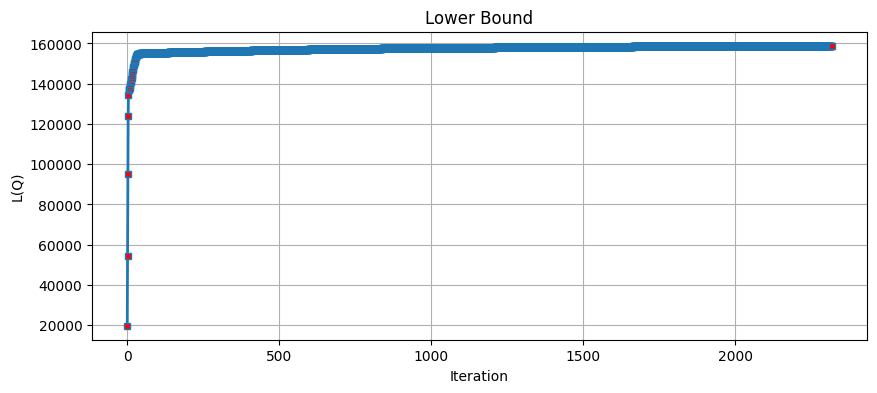

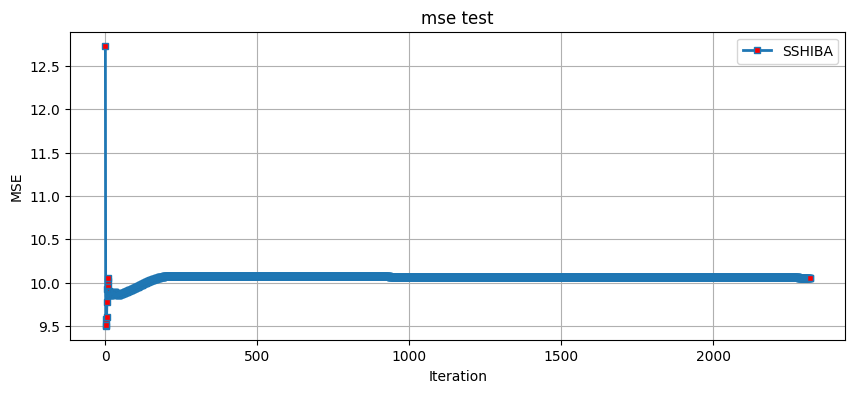

In [7]:
plot_L(myModel.L)
plt.title('Lower Bound')

plot_mse(myModel.mse)
plt.title('mse test')
plt.show()

### Sparsity in matrix W

Furthermore, we can visualize the effect of the sparsity imposed in the matrices W. This sparsity makes the model to just use the latent variables it needs and cancel the latent features that are not necessary. At the same time, the model is capable of learning latent variables that are common to both views, with information relevant to both of them, as well as some other latent variables capables of describing each view independently.

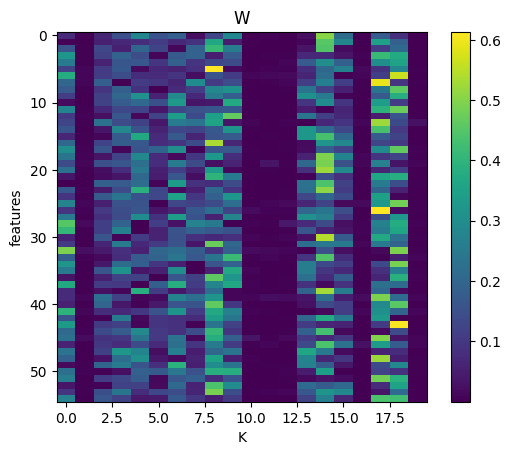

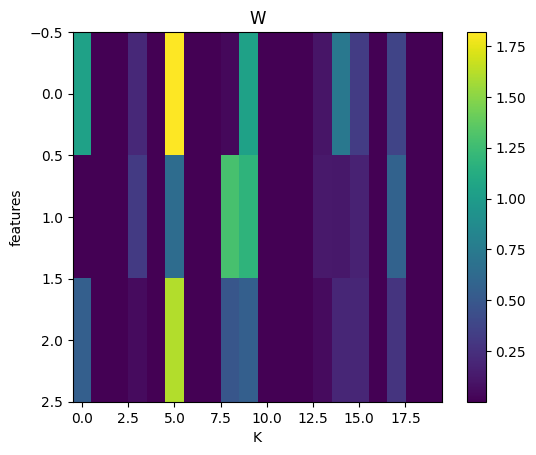

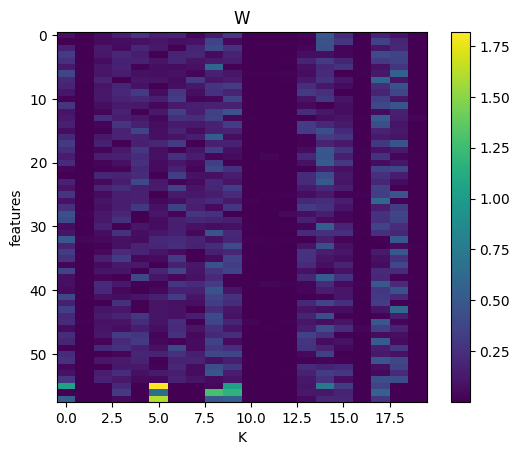

In [8]:
q = myModel.q_dist
W = np.vstack((q.W[0]['mean'],q.W[1]['mean']))
plot_W(q.W[0]['mean'])
plot_W(q.W[1]['mean'])
plot_W(W)

These results of the W matrix can also be visualized using the alpha values, which are the ones that are learnt for this purpose. Therefore, a value of alpha high enough would mean that particular latent feature is not relevant for the model and could, thus, be removed from the matrix.

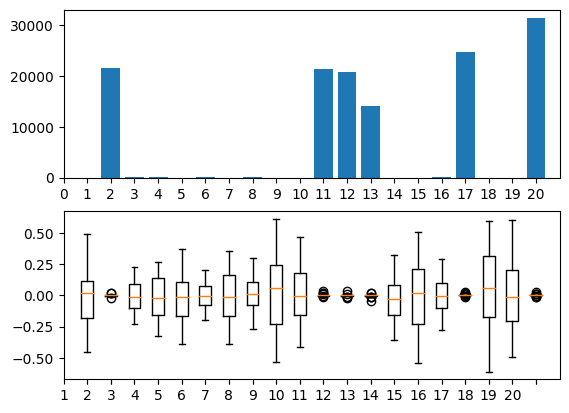

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=1)
for a in ax:
    a.set_xlim([1, myKc+1])
    a.set_xticks(range(myKc+1))
plot_alpha(q.alpha_mean(0), ax[0])
plot_weights(q.W[0]['mean'], ax[1])

In the next sections of the notebook these latent features will be automatically removed as the model is trained when their relative W value is lower than a threshold for the before mentioned features.

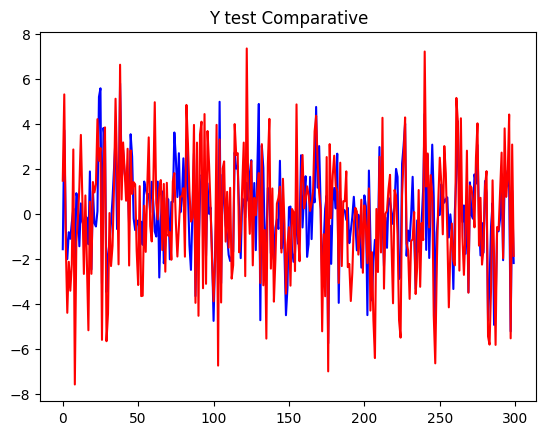

In [11]:
Y_pred_tst,var = myModel.predict([0],1,X0_tst)
plt.figure()
plt.plot(Y_pred_tst[:,0],'b')
plt.plot(Y_tst[:,0],'r')
plt.title('Y test Comparative')
plt.show()